This notebook demonstrates how to use the `MutualCoupling` class. The `MutualCoupling` class provides a relatively fast implementation of the mutual coupling systematic described in [Josaitis et al. (2021)](https://doi.org/10.1093/mnras/stac916) and updated in [Rath & Pascua (2024)](https://arxiv.org/abs/2406.08549), although it is somewhat memory intensive.

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import uvtools
from astropy import constants, units
from pyuvdata import UniformBeam

import hera_sim

%matplotlib inline

basis_vector_type was not defined, defaulting to azimuth and zenith_angle.


In [2]:
plt.rcParams["font.size"] = 12
plt.rcParams["figure.facecolor"] = "white"

# Setup

We'll choose our simulation parameters so that we have enough frequency channels, bandwidth, integrations, and observation time to perform both a delay transform and fringe-rate transform with sufficient resolution, since it is easiest to understand how the systematic behaves in fringe-rate vs delay space.

In [3]:
data_config = dict(
    Nfreqs=300,
    start_freq=140e6,
    channel_width=100e3,
    Ntimes=300,
    start_time=2458091.2234,
    integration_time=10.7,
    telescope_location=np.zeros(3),
)

In [4]:
def square_array(sep=30, side_len=4):
    array = {}
    antnum = 0
    for row in range(side_len):
        y_pos = row * sep
        for col in range(side_len):
            x_pos = col * sep
            array[antnum] = np.array([x_pos, y_pos, 0])
            antnum += 1
    return array

In [11]:
def mock_visibility(uvdata, delay_width=200e-9, ref_freq=150e6):
    """Mock up visibilities that look like foregrounds in FR vs delay.

    This function populates the data array of the provided UVData
    object with toy model visibilities that behave somewhat like
    foregrounds in the main-lobe of the beam in fringe-rate vs delay
    space. That is, the simulated visibilities are localized in
    fringe-rate and delay.
    """
    freqs = uvdata.freq_array.squeeze()
    times = np.unique(uvdata.time_array) * units.day.to("s")
    freq_mesh, time_mesh = np.meshgrid(freqs, times - times.mean())
    omega0 = units.cycle.to("rad") / units.sday.to("s")
    omega = np.array([0, 0, omega0])
    enu_antpos = uvdata.telescope.get_enu_antpos()
    ecef_antpos = uvdata.telescope.antenna_positions
    antenna_numbers = uvdata.telescope.antenna_numbers

    for ai, aj in uvdata.get_antpairs():
        if uvdata.antpair2ind(ai, aj) is None:
            continue
        i = antenna_numbers.tolist().index(ai)
        j = antenna_numbers.tolist().index(aj)
        ecef_bl = ecef_antpos[j] - ecef_antpos[i]
        enu_bl = enu_antpos[j] - enu_antpos[i]
        dbdt = np.cross(ecef_bl, omega)
        b = np.linalg.norm(ecef_bl)
        sign = np.sign(np.round(enu_bl[0], 3))
        frates = sign * freq_mesh * np.linalg.norm(dbdt) / constants.c.si.value
        blt_inds = uvdata.antpair2ind(ai, aj)
        uvdata.data_array[blt_inds, :, 0] = np.exp(
            -((delay_width * (freq_mesh - ref_freq)) ** 2)
        ) * np.exp(2j * np.pi * frates[None, :] * time_mesh)

In [6]:
test_array = {0: np.array([0, 0, 0]), 1: np.array([50, 0, 0]), 2: np.array([0, 150, 0])}

(-18.49989470376238, 75.0)

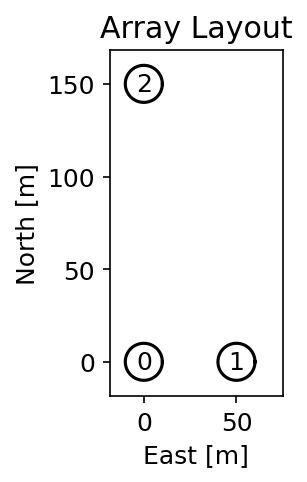

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
ax.set_title("Array Layout")
dish = 10 * np.exp(1j * np.linspace(0, 2 * np.pi, 360))
for ant, (e, n, u) in test_array.items():
    ax.plot(e + dish.real, n + dish.imag, color="k")
    ax.text(e, n, ant, ha="center", va="center")
ax.set_aspect("equal")
ax.set_xlim(ax.get_ylim()[0], 75)


**Fig. 1 |** Array layout used for a first round of simulation for building intuition.

# Basic Example

In this section we'll see how mutual coupling manifests for the small array shown above.

In [8]:
# Create a Simulator object to put simulated data into
sim = hera_sim.Simulator(array_layout=test_array, **data_config)

The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.


In [9]:
# Pull some metadata useful for plotting
freqs = sim.data.freq_array.squeeze()
times = np.unique(sim.data.time_array)
delays = uvtools.utils.fourier_freqs(freqs) * units.s.to("ns")
frates = uvtools.utils.fourier_freqs(times * units.day.to("s")) * units.Hz.to("mHz")
extent = (delays[0], delays[-1], frates[-1], frates[0])
dynamic_range = 5
plot_kwds = dict(
    freqs=freqs,
    times=times,
    set_title=False,
    draw_colorbar=False,
    cmap="inferno",
    dynamic_range=dynamic_range,
    fft_axis="both",
    freq_taper="bh",
    time_taper="bh",
)
cmap = plt.cm.inferno
norm = plt.cm.colors.LogNorm(vmin=10**-dynamic_range, vmax=1)
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

In [12]:
# Simulate toy model visibilities
mock_visibility(sim.data, delay_width=50e-9, ref_freq=sim.data.freq_array.mean())

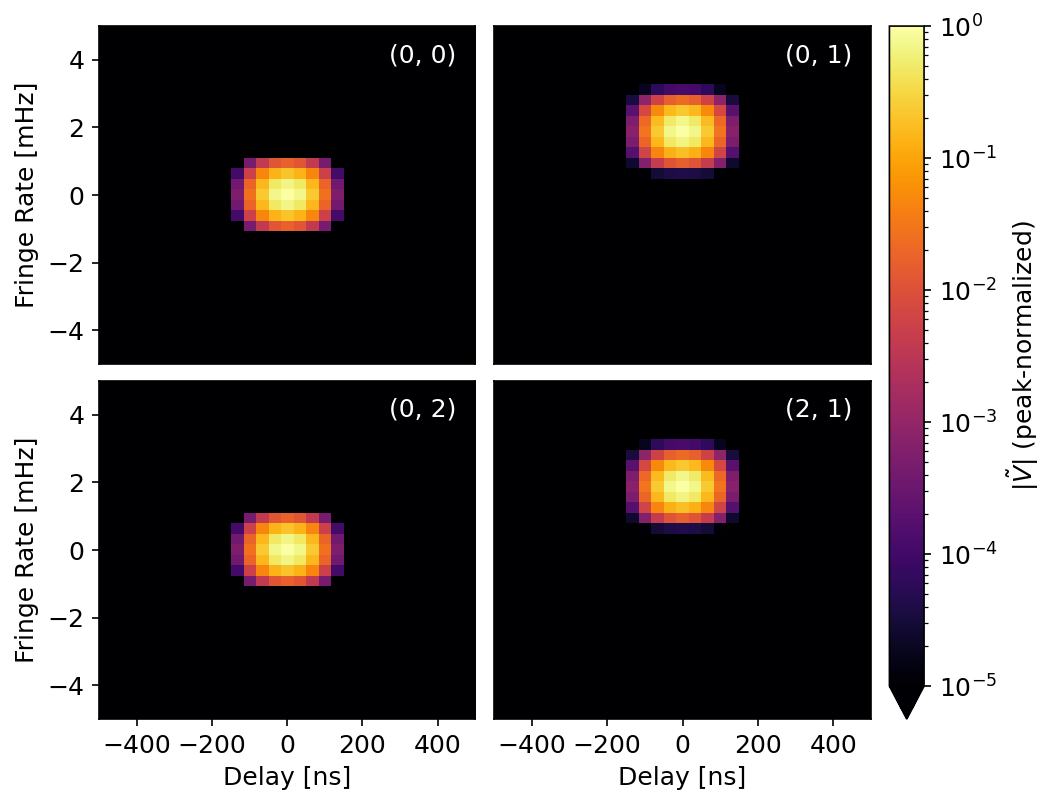

In [13]:
gridspec_kw = dict(hspace=0.05, wspace=0.05)
label_kwds = dict(color="w", ha="right", va="top")
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(8, 6), dpi=150, gridspec_kw=gridspec_kw
)
for ax in axes[0]:
    ax.xaxis.set_visible(False)
for ax in axes[:, 1]:
    ax.yaxis.set_visible(False)
for ax in axes[:, 0]:
    ax.set_ylabel("Fringe-Rate [mHz]")
for ax in axes[1]:
    ax.set_xlabel("Delay [ns]")

antpairs = [(0, 0), (0, 1), (0, 2), (2, 1)]
for (ai, aj), ax in zip(antpairs, axes.ravel()):
    vis = sim.get_data(ai, aj, "xx")
    _ = uvtools.plot.labeled_waterfall(vis, ax=ax, **plot_kwds)
    ax.text(0.95, 0.95, (ai, aj), transform=ax.transAxes, **label_kwds)
for ax in axes.ravel():
    ax.set_xlim(-500, 500)
    ax.set_ylim(-5, 5)
dly_ticks = [-400, -200, 0, 200, 400]
for ax in axes[1]:
    ax.set_xticks(dly_ticks)
cbar = fig.colorbar(smap, ax=axes, extend="min", pad=0.02)
cbar.set_label(r"|$\tilde{V}$| (peak-normalized)")

**Fig. 2 |** Fringe-rate vs delay waterfalls of the simulated data. Note that the data is simulated so that the fringe-rate is determined solely by the East-West projection of the baseline, and every baseline has its power concentrated at low delays. 

## Simulating Coupling

It's simplest to use the `Simulator` class to simulate the coupling&mdash;while the `MutualCoupling` class cares about lots of parameters, the majority of them can be obtained from the `UVData`'s metadata. The only parameters that can't be retrieved from the metadata are the **beam**, **reflection coefficient**, and **beam integral**. For simplicity, we'll be using a uniform beam and constant values for the reflection coefficient and beam integral.

In [14]:
# Choose simple coupling parameters
xt_kwargs = dict(
    uvbeam=UniformBeam(),
    reflection=np.ones(sim.Nfreqs) * 5e-2,
    omega_p=np.sqrt(constants.c.si.value / freqs),
)

In [15]:
# Actually simulate the mutual coupling
sim.add("mutual_coupling", **xt_kwargs)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


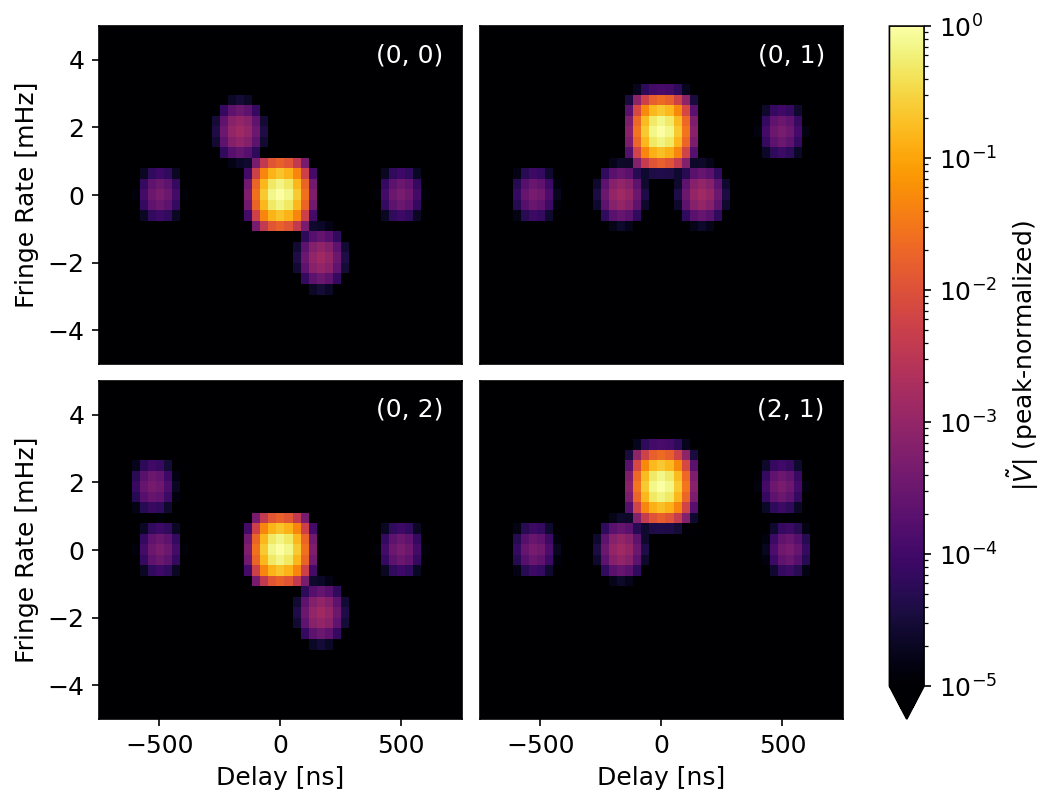

In [16]:
# Let's look at the coupled visibilities
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(8, 6), dpi=150, gridspec_kw=gridspec_kw
)
for ax in axes[0]:
    ax.xaxis.set_visible(False)
for ax in axes[:, 1]:
    ax.yaxis.set_visible(False)
for ax in axes[:, 0]:
    ax.set_ylabel("Fringe-Rate [mHz]")
for ax in axes[1]:
    ax.set_xlabel("Delay [ns]")

antpairs = [(0, 0), (0, 1), (0, 2), (2, 1)]
for (ai, aj), ax in zip(antpairs, axes.ravel()):
    vis = sim.get_data(ai, aj, "xx")
    _ = uvtools.plot.labeled_waterfall(vis, ax=ax, **plot_kwds)
    ax.text(0.95, 0.95, (ai, aj), transform=ax.transAxes, **label_kwds)
for ax in axes.ravel():
    ax.set_xlim(-750, 750)
    ax.set_ylim(-5, 5)
cbar = fig.colorbar(smap, ax=axes, extend="min")
cbar.set_label(r"|$\tilde{V}$| (peak-normalized)")

**Fig. 3 |** Coupled mock visibilities. Note that each baseline now has four additional "blobs" in its fringe-rate vs delay waterfall. Each cross-correlation has two blobs symmetrically located about zero delay at fringe-rate zero&mdash;these are the autocorrelations for each antenna in the baseline. The other blobs are coupling between baselines.

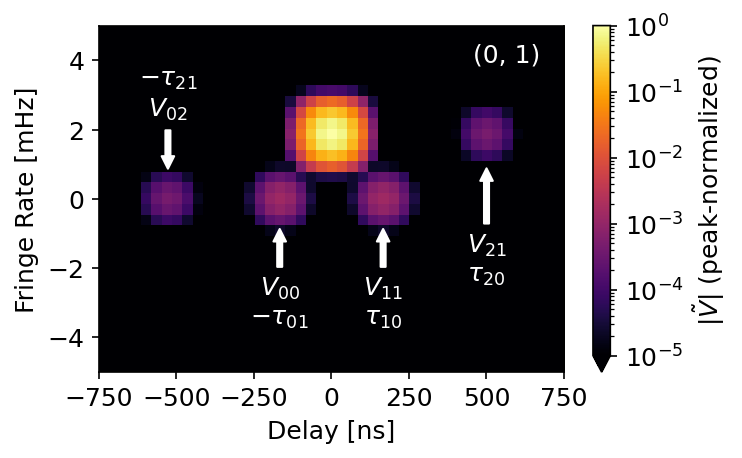

In [17]:
# Let's break this down further for one baseline
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=150)
ax.set_ylabel("Fringe-Rate [mHz]")
ax.set_xlabel("Delay [ns]")

ai, aj = 0, 1
vis = sim.get_data(ai, aj, "xx")
_ = uvtools.plot.labeled_waterfall(vis, ax=ax, **plot_kwds)

arrow_kwds = dict(
    #     length_includes_head=True,
    color="w",
    #     fill=True,
    #     width=1,
    arrowstyle="simple",
)
annotate_kwds = dict(color="w", arrowprops=arrow_kwds, ha="center", va="center")
dly_02 = -np.linalg.norm(test_array[2] - test_array[1]) / constants.c.to("m/ns").value
dly_00 = -np.linalg.norm(test_array[0] - test_array[1]) / constants.c.to("m/ns").value
dly_11 = -dly_00
dly_21 = np.linalg.norm(test_array[0] - test_array[2]) / constants.c.to("m/ns").value
ax.annotate(
    r"$-\tau_{21}$" + "\n" + r"$V_{02}$", (dly_02, 0.75), (dly_02, 3), **annotate_kwds
)
ax.annotate(
    r"$V_{00}$" + "\n" + r"$-\tau_{01}$", (dly_00, -0.75), (dly_00, -3), **annotate_kwds
)
ax.annotate(
    r"$V_{11}$" + "\n" + r"$\tau_{10}$", (dly_11, -0.75), (dly_11, -3), **annotate_kwds
)
ax.annotate(
    r"$V_{21}$" + "\n" + r"$\tau_{20}$", (dly_21, 1), (dly_21, -1.75), **annotate_kwds
)

ax.text(0.95, 0.95, (ai, aj), transform=ax.transAxes, **label_kwds)
ax.set_xlim(-750, 750)
ax.set_ylim(-5, 5)

cbar = fig.colorbar(smap, ax=ax, extend="min")
cbar.set_label(r"|$\tilde{V}$| (peak-normalized)")

**Fig. 4 |** Coupled visibility for the purely East-West oriented baseline. The brightest blob is the uncoupled visibility. The two blobs at about $\pm$200 ns and zero fringe-rate are the autocorrelations (recall that this is a 50-meter baseline, so the light travel time is a bit under 200 ns). The blob at about -500 ns and zero fringe-rate is the visibility from the (0,2) baseline, which doesn't fringe since it's purely North-South oriented. The blob at about +500 ns and fringing at about 2 mHz is the visibility from the (2,1) baseline (it has the same East-West projection as the (0,1) baseline, and so it fringes the same according to our toy model).

# Bigger Example

Let's do the same thing we did in the previous section, but now with a bigger array.

In [18]:
array_layout = square_array(sep=50, side_len=3)
sim = hera_sim.Simulator(array_layout=array_layout, **data_config)

The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.


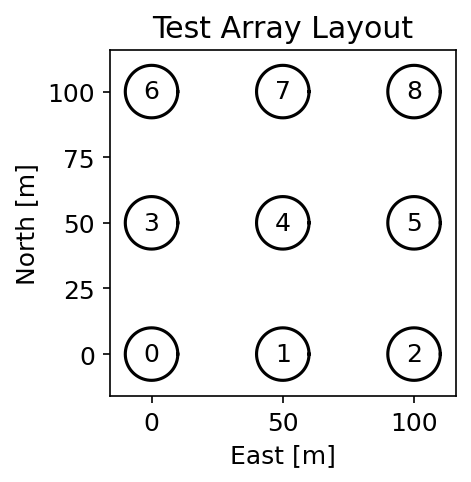

In [19]:
# Let's take a look at the array
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
ax.set_title("Test Array Layout")
ax.set_aspect("equal")
dish = 10 * np.exp(1j * np.linspace(0, 2 * np.pi, 360))
for ant, (e, n, u) in array_layout.items():
    ax.plot(e + dish.real, n + dish.imag, color="k")
    ax.text(e, n, ant, ha="center", va="center")
ax.set_xlim(*ax.get_ylim());

**Fig. 5 |** Small square array with 30-meter separation between adjacent antennas.

In [20]:
# Now simulate data and coupling
mock_visibility(sim.data, delay_width=50e-9, ref_freq=sim.data.freq_array.mean())
sim.add("mutual_coupling", **xt_kwargs)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


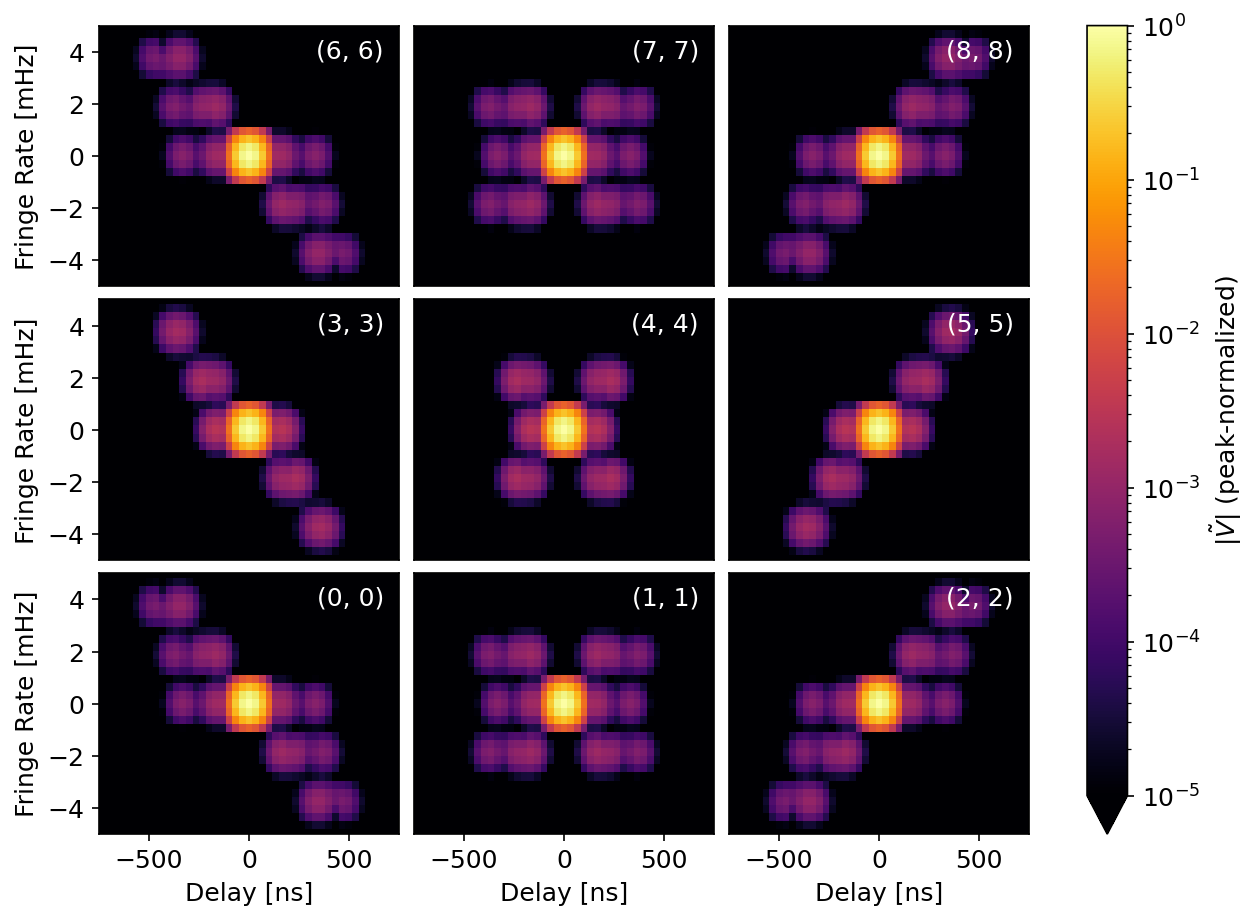

In [21]:
# Let's look at some visibilities; first the autocorrelations
gridspec_kw["wspace"] = 0.05
fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(10, 7), dpi=150, gridspec_kw=gridspec_kw
)
for ax in axes[:, 1:].ravel():
    ax.yaxis.set_visible(False)
for ax in axes[:-1, :].ravel():
    ax.xaxis.set_visible(False)
for ax in axes[:, 0]:
    ax.set_ylabel("Fringe-Rate [mHz]")
for ax in axes[-1]:
    ax.set_xlabel("Delay [ns]")

ants = [6, 7, 8, 3, 4, 5, 0, 1, 2]
for ant, ax in zip(ants, axes.ravel()):
    vis = sim.get_data(ant, ant, "xx")
    _ = uvtools.plot.labeled_waterfall(vis, ax=ax, **plot_kwds)
    ax.text(0.95, 0.95, (ant, ant), transform=ax.transAxes, **label_kwds)
    ax.set_xlim(-750, 750)
    ax.set_ylim(-5, 5)
cbar = fig.colorbar(smap, ax=axes, extend="min")
cbar.set_label(r"|$\tilde{V}$| (peak-normalized)")

**Fig. 6 |** Autocorrelations with coupling, with plots arranged to match the array layout. Note that antennas on the East or West edge of the array have a slash-like feature in their fringe-rate vs delay waterfalls, with the orientation of the slash determined by which edge of the array they are on.

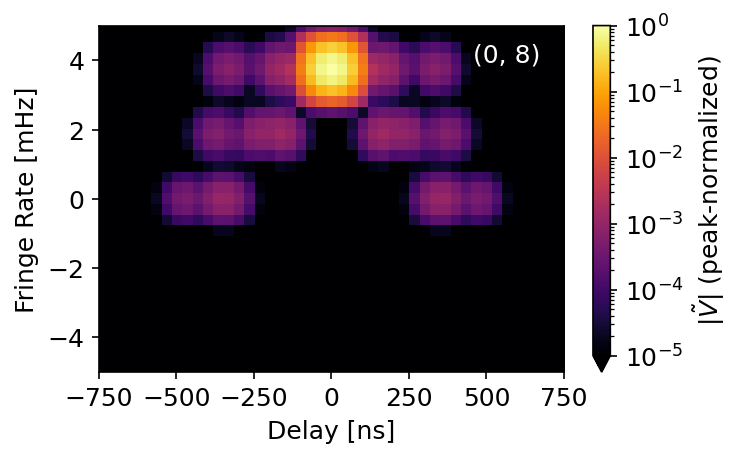

In [22]:
# What about a cross-correlation?
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=150)
ax.set_ylabel("Fringe-Rate [mHz]")
ax.set_xlabel("Delay [ns]")

ai, aj = 0, 8
vis = sim.get_data(ai, aj, "xx")
_ = uvtools.plot.labeled_waterfall(vis, ax=ax, **plot_kwds)
ax.text(0.95, 0.95, (ai, aj), transform=ax.transAxes, **label_kwds)
ax.set_xlim(-750, 750)
ax.set_ylim(-5, 5)
cbar = fig.colorbar(smap, ax=ax, extend="min")
cbar.set_label(r"|$\tilde{V}$| (peak-normalized)")

**Fig. 7 |** Visibility for the North-East baseline formed with antennas at the array corners. The coupled (0,x) and (x,8) visibilities are coupled into this one, and all of these are either North-South oriented or have a positive eastward projection, so the coupled visibilities all come in with positive fringe-rate.

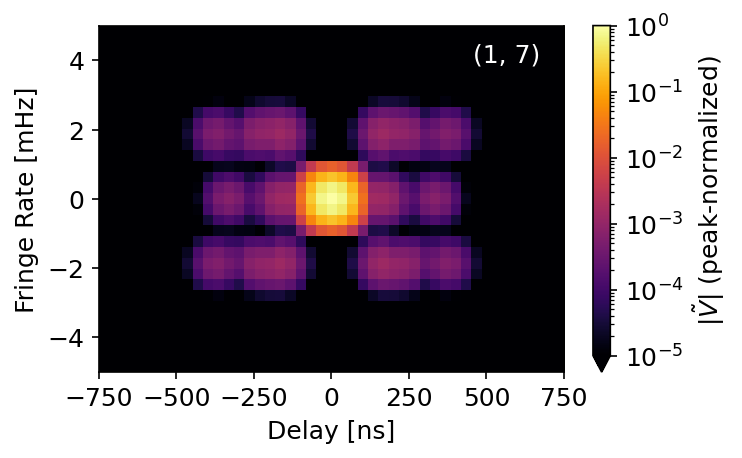

In [23]:
# Let's look at a different cross-correlation
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=150)
ax.set_ylabel("Fringe-Rate [mHz]")
ax.set_xlabel("Delay [ns]")

ai, aj = 1, 7
vis = sim.get_data(ai, aj, "xx")
_ = uvtools.plot.labeled_waterfall(vis, ax=ax, **plot_kwds)
ax.text(0.95, 0.95, (ai, aj), transform=ax.transAxes, **label_kwds)
ax.set_xlim(-750, 750)
ax.set_ylim(-5, 5)
cbar = fig.colorbar(smap, ax=ax, extend="min")
cbar.set_label(r"|$\tilde{V}$| (peak-normalized)")

**Fig. 8 |** Visibility for the long North-South baseline using antennas in the middle column. Since the array is symmetric about the baseline, the visibilities couple in fringe-rate vs delay space in a symmetric way.